In [1]:
import torch
import matplotlib.pyplot as plt
from typing import List, Optional
import copy
import torchvision

torch.manual_seed(0)

In [2]:
class NAGGS(torch.optim.Optimizer):
    """Class NAGGS implements algorithm 1 from [1] which stands for the Semi
    Implicit integration of the Nesterov Accelerated Gradient (NAG) flow.

     References
    ----------
    .. [1] NAG-GS: Semi-Implicit, Accelerated and Robust Stochastic Optimizer
    """

    def __init__(self, params, lr=1e-2, mu=1.0, gamma=1.0):
        if lr < 0.0:
            raise ValueError(f"Invalid alpha: {lr}")
        if mu < 0.0:
            raise ValueError(f"Invalid mu: {mu}")

        defaults = dict(lr=lr, mu=mu, gamma=gamma)
        super().__init__(params, defaults)

    def __setstate__(self, state):
        super().__setstate__(state)

    @torch.no_grad()
    def step(self, closure=None):
        """Performs a single optimization step.

        Arguments
        ---------
            closure (callable, optional): A closure that reevaluates the model
                and returns the loss.
        """
        loss = None
        if closure is not None:
            with T.enable_grad():
                loss = closure()

        for group in self.param_groups:
            params_with_grad = []
            grads = []
            v_list = []

            for p in group['params']:
                if p.grad is not None:
                    params_with_grad.append(p)
                    grads.append(p.grad)

                    state = self.state[p]
                    # Initialization
                    if len(state) == 0:
                        state['v'] = torch.clone(p).detach()

                    v_list.append(state['v'])

            naggs(params_with_grad,
                 grads,
                 v_list,
                 alpha=group['lr'],
                 mu=group['mu'],
                 gamma=group['gamma'])

        return loss


def naggs(params: List[torch.Tensor], grads: List[torch.Tensor],
         v_list: List[Optional[torch.Tensor]], alpha: float, mu: float,
         gamma: float):
    """Function naggs performs NAGGS algorithm computation.
    """

    for i, param in enumerate(params):
        grad = grads[i]
        v = v_list[i]
        # Update v
        v.add_(mu*param - grad, alpha=alpha/gamma)
        v.div_(1 + alpha*mu/gamma)

        # Update parameters
        param.add_(v, alpha=alpha)
        param.div_(1+alpha)


## Logistic regression

In [3]:
batch_size=128

In [4]:
train_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('./', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size, shuffle=True)

test_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('./', train=False, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size, shuffle=True)

100%|██████████| 9912422/9912422 [00:00<00:00, 13510859.44it/s]


Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 53106397.99it/s]

Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 3526157.45it/s]


Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 24708857.03it/s]

Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



In [5]:
class LogisticRegression(torch.nn.Module):
     def __init__(self, input_dim, output_dim):
        super(LogisticRegression, self).__init__()
        self.linear = torch.nn.Linear(input_dim, output_dim)
     
     def forward(self, x):
        outputs = self.linear(x.reshape(x.shape[0], -1))
        return outputs
    

In [6]:
epochs = 10
input_dim = 28 * 28
output_dim = 10
learning_rate = 0.5
mu = 1.

In [7]:
model_sgd = LogisticRegression(input_dim,output_dim)
model_nag = copy.deepcopy(model_sgd)
criterion = torch.nn.CrossEntropyLoss()

In [8]:
sgd = torch.optim.SGD(model_sgd.parameters(), lr=learning_rate, momentum=0.9, weight_decay=0)
nag4_opt = NAGGS(model_nag.parameters(), lr=learning_rate, mu=mu)

In [9]:
train_loss = {
    "SGD Momentum": [],
    "NAGGS": []
}

test_loss = {
    "SGD Momentum": [],
    "NAGGS": []
}

train_acc = {
    "SGD Momentum": [],
    "NAGGS": []
}

test_acc = {
    "SGD Momentum": [],
    "NAGGS": []
}

In [10]:
models = {
    "SGD Momentum": model_sgd,
    "NAGGS": model_nag
}
optimizers = {
    "SGD Momentum": sgd,
    "NAGGS": nag4_opt
}

In [11]:
def train(network, optimizer):
    network.train()
    for data, target in train_loader:
        optimizer.zero_grad()
        output = network(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()     
#             torch.save(network.state_dict(), '/results/model.pth')
#             torch.save(optimizer.state_dict(), '/results/optimizer.pth')

In [12]:
def evaluate(model, train_loss, test_loss, train_acc, test_acc):
    model.eval()
    cur_train_loss = 0
    total_num_samples = 0
    correct_samples = 0
    for data, target in train_loader:
        output = model(data)
        loss = criterion(output, target)
        cur_train_loss += loss.item()
        total_num_samples += data.shape[0]
        prediction = output.data.max(1, keepdim=True)[1]
        correct_samples += prediction.eq(target.data.view_as(prediction)).sum().item()
        
    train_acc.append(correct_samples / total_num_samples)
    train_loss.append(cur_train_loss)
    total_num_samples = 0
    cur_test_loss = 0
    correct_samples = 0
    for data, target in test_loader:
        output = model(data)
        loss = criterion(output, target)
        cur_test_loss += loss.item()
        total_num_samples += data.shape[0]
        prediction = output.data.max(1, keepdim=True)[1]
        correct_samples += prediction.eq(target.data.view_as(prediction)).sum().item()
        
    test_acc.append(correct_samples / total_num_samples)
    test_loss.append(cur_test_loss)

In [13]:
m_name = "SGD Momentum"
train_loss[m_name] = []
test_loss[m_name] = []
train_acc[m_name] = []
test_acc[m_name] = []
evaluate(models[m_name], train_loss[m_name], test_loss[m_name],
            train_acc[m_name], test_acc[m_name])
for i in range(epochs):
    train(models[m_name], optimizers[m_name])
    evaluate(models[m_name], train_loss[m_name], test_loss[m_name],
            train_acc[m_name], test_acc[m_name])
    print(train_loss[m_name][-1], test_loss[m_name][-1], train_acc[m_name][-1], test_acc[m_name][-1])

1302.826554208994 230.44011592306197 0.8888 0.8892
1387.9708197712898 269.2823525071144 0.88125 0.8771
1544.3647080659866 271.44075870513916 0.875 0.8735
1339.1880411803722 244.8778487443924 0.8928 0.893
1733.8025943040848 328.3237339258194 0.8640333333333333 0.8593
1399.4662087857723 263.82002082467034 0.8862833333333333 0.8809
1258.97850304842 256.644859790802 0.9006 0.892
1432.1945928931236 283.94965666532516 0.8902333333333333 0.8857
1525.5163508057594 306.81267178058624 0.88005 0.8751
1306.260425388813 255.22261202335358 0.8939666666666667 0.8867


In [14]:
m_name = "NAGGS"
train_loss[m_name] = []
test_loss[m_name] = []
train_acc[m_name] = []
test_acc[m_name] = []
evaluate(models[m_name], train_loss[m_name], test_loss[m_name],
            train_acc[m_name], test_acc[m_name])
for i in range(epochs):
    train(models[m_name], optimizers[m_name])
    evaluate(models[m_name], train_loss[m_name], test_loss[m_name],
            train_acc[m_name], test_acc[m_name])
    print(train_loss[m_name][-1], test_loss[m_name][-1], train_acc[m_name][-1], test_acc[m_name][-1])

142.55056203901768 24.227425158023834 0.9133833333333333 0.9135
152.29134091734886 27.389981254935265 0.9038 0.8991
139.70526038855314 24.954152286052704 0.9133333333333333 0.9079
132.84066399931908 24.855547413229942 0.9208333333333333 0.9146
127.9591054469347 23.54251554608345 0.9240333333333334 0.9204
128.5343902334571 23.54671870917082 0.9228166666666666 0.9157
125.08921175822616 23.128665510565042 0.9246666666666666 0.9184
129.82737474888563 24.712183132767677 0.9225333333333333 0.916
127.4881307631731 24.033220767974854 0.9246833333333333 0.9172
125.15742874145508 23.96458864212036 0.9259666666666667 0.9176


Text(0.5, 1.0, 'lr=0.5')

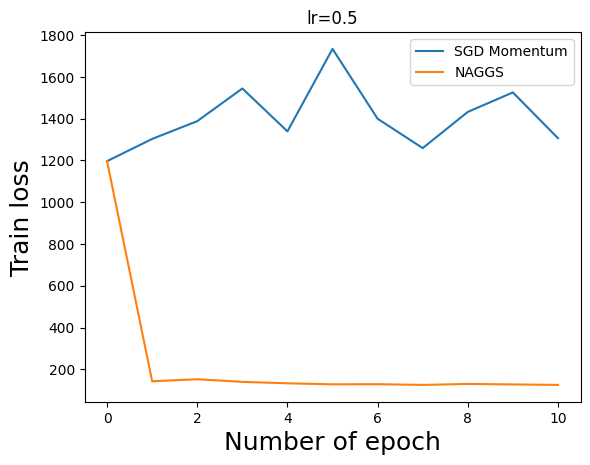

In [15]:
for m_name in train_loss:
    plt.plot(train_loss[m_name], label=m_name)
plt.legend()
plt.xlabel("Number of epoch", fontsize=18)
plt.ylabel("Train loss", fontsize=18)
plt.title("lr={}".format(learning_rate))

Text(0.5, 1.0, 'lr=0.5')

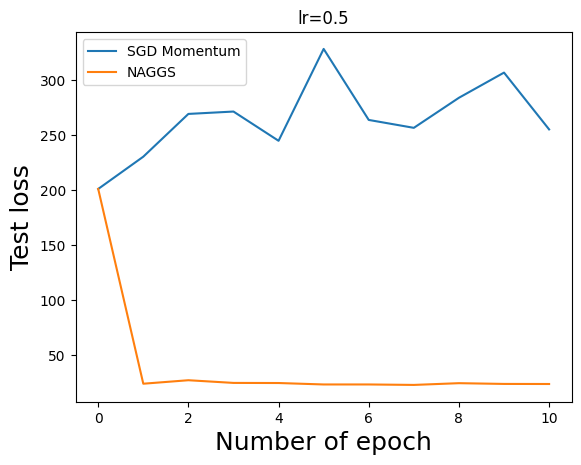

In [16]:
for m_name in test_loss:
    plt.plot(test_loss[m_name], label=m_name)
plt.legend()
plt.xlabel("Number of epoch", fontsize=18)
plt.ylabel("Test loss", fontsize=18)
plt.title("lr={}".format(learning_rate))

Text(0.5, 1.0, 'lr=0.5')

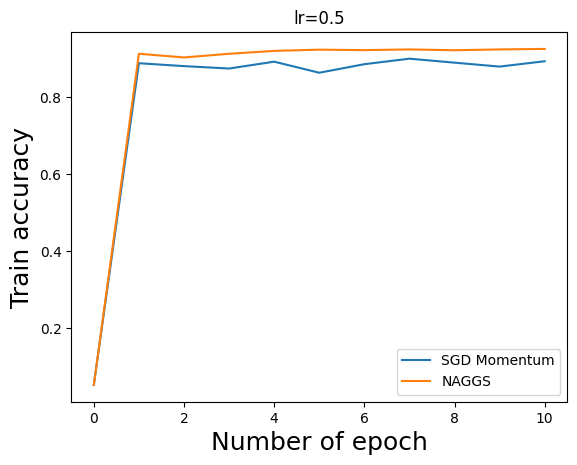

In [17]:
for m_name in train_acc:
    plt.plot(train_acc[m_name], label=m_name)
plt.legend()
plt.xlabel("Number of epoch", fontsize=18)
plt.ylabel("Train accuracy", fontsize=18)
plt.title("lr={}".format(learning_rate))

Text(0.5, 1.0, 'lr=0.5')

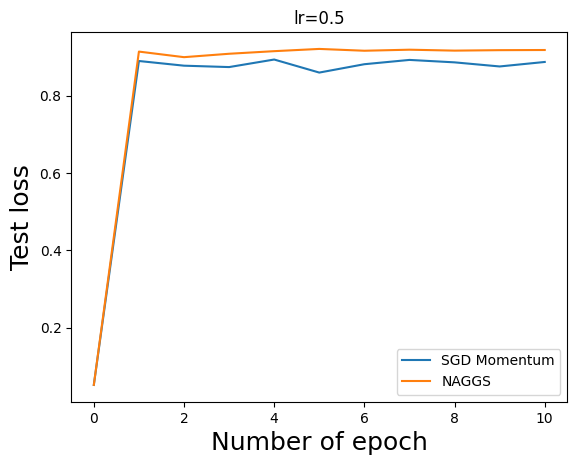

In [18]:
for m_name in test_acc:
    plt.plot(test_acc[m_name], label=m_name)
plt.legend()
plt.xlabel("Number of epoch", fontsize=18)
plt.ylabel("Test loss", fontsize=18)
plt.title("lr={}".format(learning_rate))